In [37]:
import json
import pandas as pd
import numpy as np
import sys
import os
import shutil
sys.path.insert(0,'/Users/sanjivjha/IMP-OIC/')
from utils.extractframes import FrameExtractor
import graphene
#from inference.gpt_ask import run_gpt
directory_path = 'STAR_eval/Charades'


In [38]:
QA_ds = pd.read_json('STAR_eval/STAR_val.json')
QA_ds.head()

question_id                                   question video_id  \
0  Interaction_T1_13  Which object was tidied up by the person?    6H78U   
1  Interaction_T1_14  Which object was tidied up by the person?    6H78U   
2  Interaction_T1_31     Which object was thrown by the person?    RNLTR   
3  Interaction_T1_32   Which object was put down by the person?    RNLTR   
4  Interaction_T1_40  Which object was tidied up by the person?    VNQTH   

   start   end               answer  \
0   11.1  19.6         The clothes.   
1   15.6  22.7         The clothes.   
2    7.3  13.5         The clothes.   
3   11.6  16.4            The shoe.   
4    2.7   9.2  The closet/cabinet.   

                                    question_program  \
0  [{'function': 'Situations', 'value_input': []}...   
1  [{'function': 'Situations', 'value_input': []}...   
2  [{'function': 'Situations', 'value_input': []}...   
3  [{'function': 'Situations', 'value_input': []}...   
4  [{'function': 'Situations', 'value_input': []}...   

                                             choices  \
0  [{'choice_id': 0, 'choice': 'The closet/cabine...   
1  [{'choice_id': 0, 'choice': 'The blanket.', 'c...   
2  [{'choice_id': 0, 'choice': 'The pillow.', 'ch...   
3  [{'choice_id': 0, 'choice': 'The food.', 'choi...   
4  [{'choice_id': 0, 'choice': 'The broom.', 'cho...   

                                          situations  
0  {'000206': {'rel_pairs': [['o000', 'o027'], ['...  
1  {'000289': {'rel_pairs': [['o000', 'o027'], ['...  
2  {'000132': {'rel_pairs': [['o000', 'o019'], ['...  
3  {'000202': {'rel_pairs': [['o000', 'o019'], ['...  
4  {'000110': {'rel_pairs': [['o000', 'o014'], ['...

In [39]:
QA_ds_questions = QA_ds.loc[:, ['question_id','question','video_id','start','end','answer', 'choices']]

In [40]:
QA = QA_ds_questions.groupby(['question_id','video_id']).sum().reset_index()#.to_csv('STAR_eval/question_set.csv')

QA.head()

question_id video_id  \
0    Feasibility_T2_10    K7VCU   
1  Feasibility_T2_1027    SMVKB   
2  Feasibility_T2_1034    G4E4S   
3  Feasibility_T2_1046    MQGVS   
4  Feasibility_T2_1048    MQGVS   

                                            question  start   end  \
0  What else is the person able to do with the dish?    0.0   9.1   
1  What else is the person able to do with the door?   16.5  23.6   
2  What else is the person able to do with the cl...    4.7   9.6   
3  What else is the person able to do with the bl...    3.0   9.7   
4  What else is the person able to do with the bl...    5.9  13.0   

                  answer                                            choices  
0         Take the dish.  [{'choice_id': 0, 'choice': 'Put down the dish...  
1        Close the door.  [{'choice_id': 0, 'choice': 'Close the door.',...  
2      Wash the clothes.  [{'choice_id': 0, 'choice': 'Sit on the clothe...  
3  Put down the blanket.  [{'choice_id': 0, 'choice': 'Close the blanket...  
4  Put down the blanket.  [{'choice_id': 0, 'choice': 'Put down the blan...

In [79]:
import ffmpeg

def segment_video(input_path, output_path, start, end):
    input_file = ffmpeg.input('/Users/sanjivjha/IMP-OIC/STAR_eval/Charades/'+input_path+'.mp4')
    duration = int(end-start)
    output_file = ffmpeg.output(input_file.trim(start=start, duration = duration).filter('setpts','PTS-STARTPTS'), '/Users/sanjivjha/IMP-OIC/STAR_eval/Charades/trim/'+output_path+'.mp4')
    ffmpeg.run(output_file)

In [70]:
def run_oic(video_id, question, choices, start,end):
    TEMP_DIR = "temp"
    CAM_PATH = "cam"
    OUT_DIR = "out"

    if os.path.isdir(TEMP_DIR):
        shutil.rmtree(TEMP_DIR) 
    
    for video in os.scandir(directory_path):
        if video.is_file():
            if os.path.splitext(video.name)[0] == video_id:
                print('processing {}'.format(video_id))
                print(video_id, question, choices, start, end)
                segment_video(os.path.splitext(video.name)[0],os.path.splitext(video.name)[0],start,end)
                
                ex = FrameExtractor(30, '/Users/sanjivjha/IMP-OIC/STAR_eval/Charades/trim/'+video.name)
                ex.main()
                g = graphene.Graphene(0.3, 0.6)

                if not os.path.isdir(OUT_DIR):
                    os.mkdir(OUT_DIR)
                text = os.path.splitext(video.name)[0]+'graph2text.txt'
                img_path = directory_path+'/trim/'+os.path.splitext(video.name)[0]+'-opencv'
                visual = os.path.splitext(video.name)[0]+'tg.png'
                #g.run_online(text)

                g.classify_images(img_path)
                graph_path = TEMP_DIR
                g.generate_temporal_graph_frames(graph_path, img_path)

                #g.generate_temporal_graph(graph_path)

                g.tg.to_plot(os.path.join(OUT_DIR, visual))

                g.tg.to_text(os.path.join(OUT_DIR,text))
                
                if os.path.isfile(OUT_DIR+'/'+text):
                    with open(OUT_DIR+'/'+text) as f:
                        context = f.readline()
                        print(context)
                    
                        #run_gpt(context, question + choices)

processing 6H78U
6H78U Which object was tidied up by the person? Options: The closet/cabinet.The blanket.The clothes.The table. 11.1 19.6


ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disab

Creating frame graph...
-------------
Inserting framegraph with id 0
-------------
Creating new node man_1460 for man and match confidence -1
Creating new node glass_00cd for glass and match confidence -1
Creating new node man_20c9 for man and match confidence -1
Creating new node shirt_a543 for shirt and match confidence -1
Creating new node head_a49d for head and match confidence -1
Creating new node pant_8514 for pant and match confidence -1
Creating new node hair_cb11 for hair and match confidence -1
Creating new edge: man wearing glass
Creating new edge: man has head
Creating new edge: man wearing pant
Creating new edge: man wearing shirt
Creating new edge: man has hair
Creating frame graph...
-------------
Inserting framegraph with id 1
-------------
Updating node man_20c9 with man and match confidence 0.8411167990534244
Updating node glass_00cd with glass and match confidence 0.8045889382437392
Updating node shirt_a543 with shirt and match confidence 0.7001140899942029
Updating 

/Users/sanjivjha/IMP-OIC/structures/graph.py:178: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


Creating frame graph...
-------------
Inserting framegraph with id 21
-------------
Updating node man_d97a with man and match confidence 0.8459224385687563
Updating node hair_cb11 with hair and match confidence 0.7999143851375672
Updating node head_a49d with head and match confidence 0.8831993008780781
Updating node person_6187 with person and match confidence 0.7858490261608709
Updating edge: man has hair
Updating edge: man has head
Updating edge: head of person
Creating frame graph...
-------------
Inserting framegraph with id 22
-------------
Updating node man_d97a with man and match confidence 0.8795533682508743
Updating node hair_cb11 with hair and match confidence 0.7972336603425011
Updating node shirt_a543 with shirt and match confidence 0.7701042094216428
Updating node head_a49d with head and match confidence 0.879663743739509
Updating edge: man has hair
Updating edge: man wearing shirt
Updating edge: head of man
Creating frame graph...
-------------
Inserting framegraph with i

ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 14.0.3 (clang-1403.0.22.14.1)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.0 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disab

KeyboardInterrupt: 

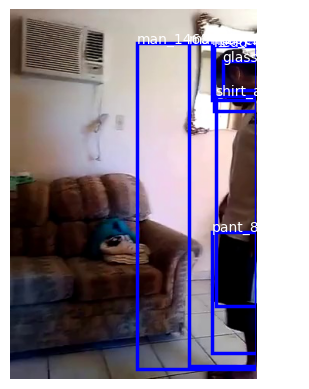

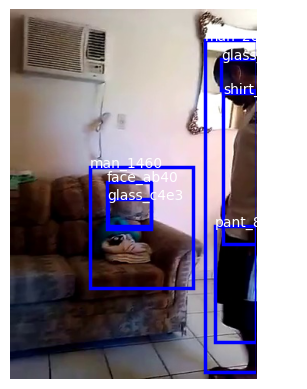

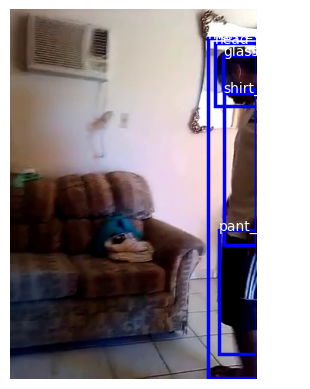

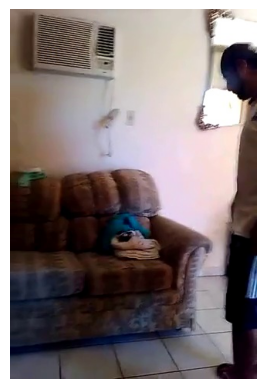

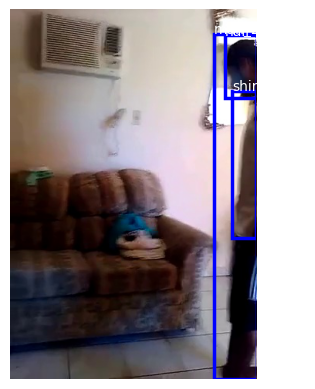

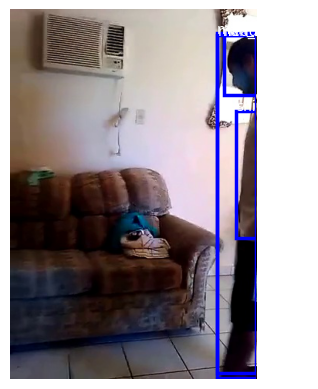

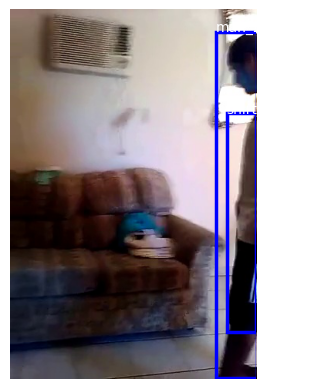

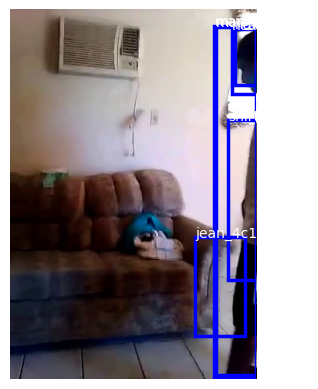

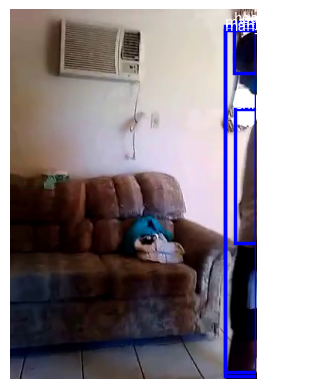

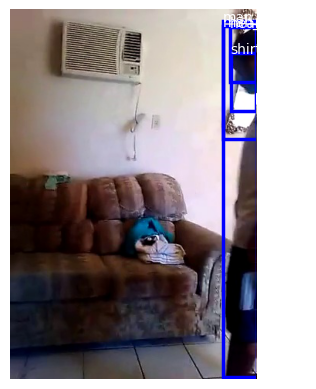

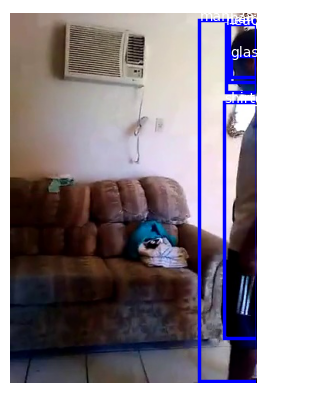

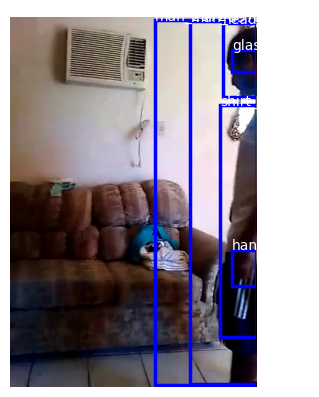

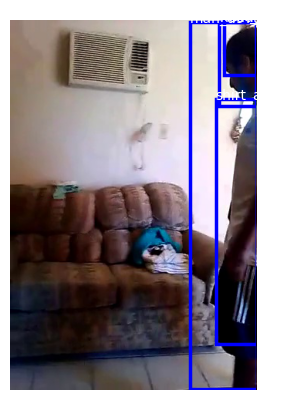

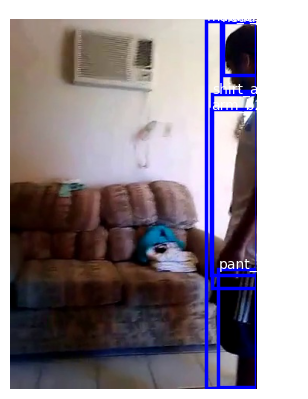

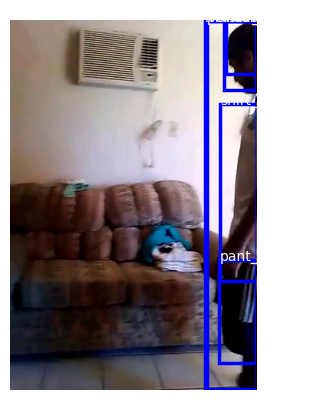

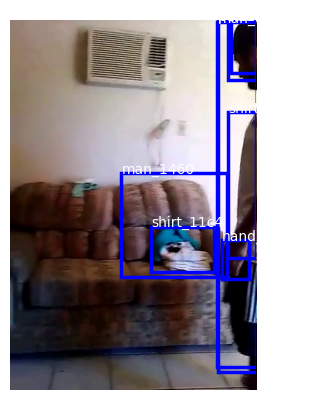

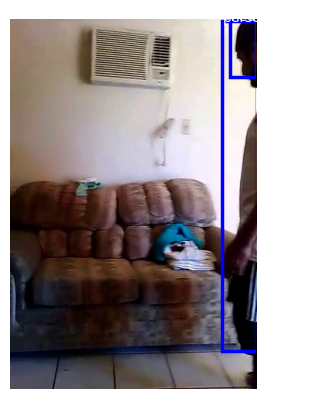

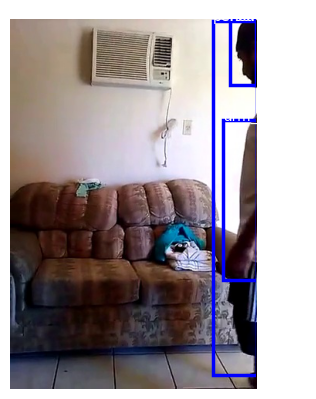

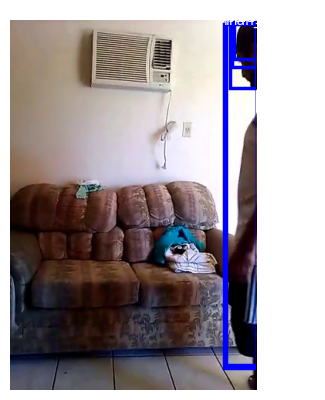

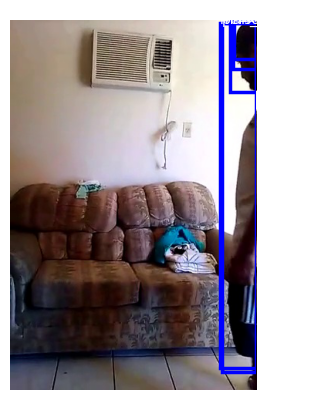

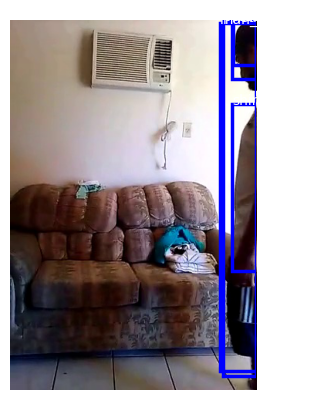

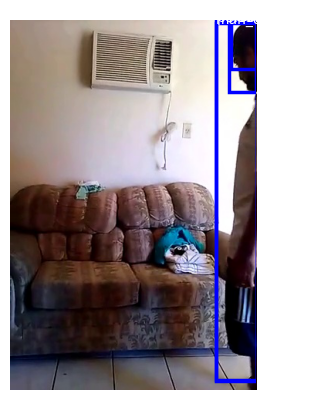

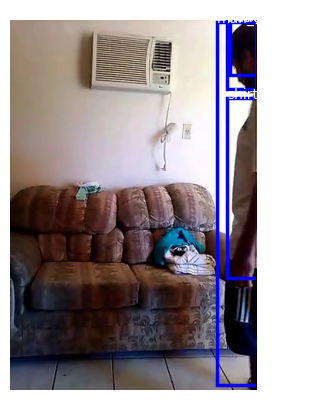

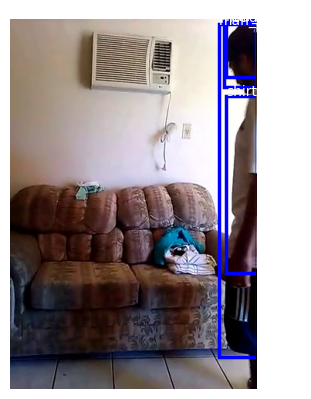

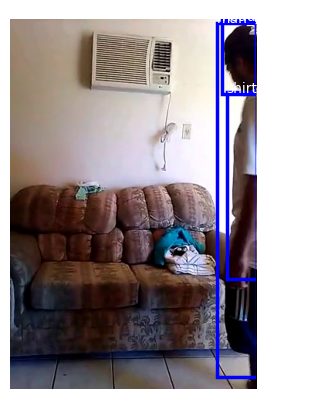

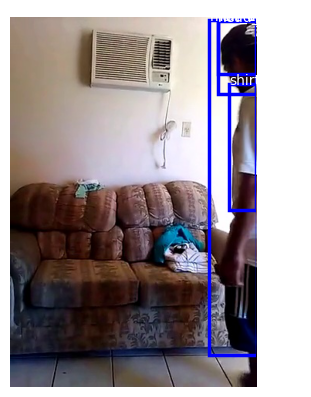

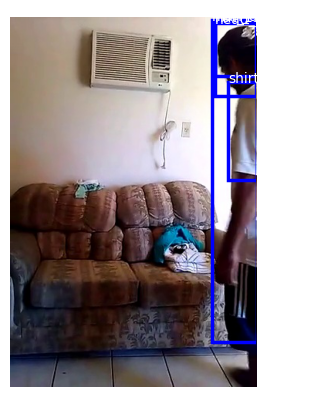

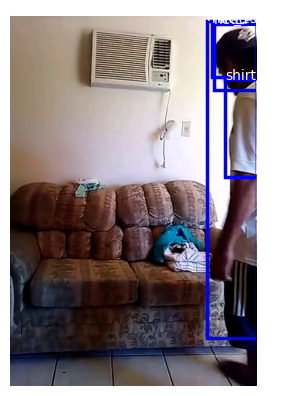

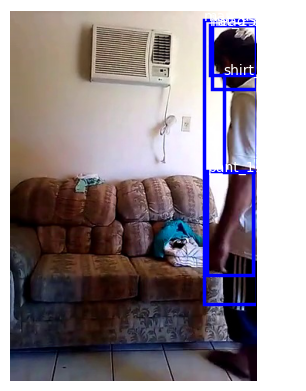

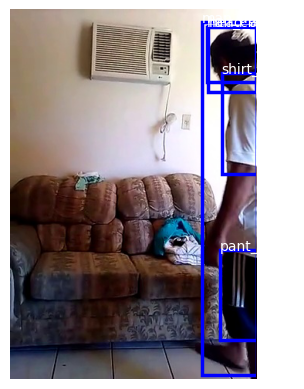

In [80]:
q_ids = QA['question_id'].unique()

for q in q_ids:
    choices = 'Options: '
    que = QA.query("question_id == '"+q+"'")
    video_id = que['video_id'].values[0]
    question = que['question'].values[0]
    start = que['start'].values[0]
    end = que['end'].values[0]
    for choice in que['choices']:
        for c in choice:
            choices+=c['choice']
    
    run_oic(video_id, question, choices, start, end)
    